# Fine-Tuning ChemBERTa


https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/examples/ZINC250K_Transfer_Learning_With_HuggingFace_tox21.ipynb


## Libraries


In [1]:
import os
import shutil

import pickle

import numpy as np

import torch
import torch.nn as nn

import pandas as pd

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import EvalPrediction
from transformers import DataCollatorWithPadding

import datasets
from datasets import load_from_disk
from datasets import concatenate_datasets


import matplotlib.pyplot as plt

from scipy.signal import find_peaks

from huggingface_hub import login

from typing import Optional

2024-08-25 05:43:35.167301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 05:43:35.167425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 05:43:35.295779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 05:43:35.483776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 05:43:37.049327: W tensorflow/compiler/tf2

## Preamble


In [2]:
# 1. Choose model
MODEL_NAME = "DeepChem/ChemBERTa-5M-MTR"
MODEL_SUFFIX = MODEL_NAME.split("/")[1]


print(f"Model: {MODEL_NAME}")

Dataset: comp
Model: DeepChem/ChemBERTa-5M-MTR


## Datasets


In [3]:
# Dataset folder
DATASET_FOLDER_PATH = "/datasets"

In [4]:
## Need to use the keep_in_memory, because the dataset folder is in read-only

train_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "train_comp"), keep_in_memory=True)
val_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "val_comp"), keep_in_memory=True)
test_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_comp"), keep_in_memory=True)


#Load exp dataset
train_dataset_exp = load_from_disk(os.path.join("/storage/train_exp.hf"), keep_in_memory=True)
val_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_exp"), keep_in_memory=True)
test_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_exp"), keep_in_memory=True)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [6]:
train_dataset_comp = train_dataset_comp.rename_column("spectrum", "labels")
train_dataset_exp = train_dataset_exp.rename_column("spectrum", "labels")

val_dataset_comp = val_dataset_comp.rename_column("spectrum", "labels")
val_dataset_exp = val_dataset_exp.rename_column("spectrum", "labels")

test_dataset_comp = test_dataset_comp.rename_column("spectrum", "labels")
test_dataset_exp = test_dataset_exp.rename_column("spectrum", "labels")

In [7]:
def truncate_spectrum(line):

    spectrum_truncated = line["labels"][0:800]
    line["labels"] = 1000 * np.array(spectrum_truncated)

    return line

In [8]:
train_dataset_comp = train_dataset_comp.map(truncate_spectrum)
train_dataset_exp = train_dataset_exp.map(truncate_spectrum)

val_dataset_comp = val_dataset_comp.map(truncate_spectrum)
val_dataset_exp = val_dataset_exp.map(truncate_spectrum)

test_dataset_comp = test_dataset_comp.map(truncate_spectrum)
test_dataset_exp = test_dataset_exp.map(truncate_spectrum)

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

## Tokenizer


In [9]:
# Models at https://huggingface.co/DeepChem

HF_TOKEN = "" #HF Login Token goes here

model_cache = "/storage/smiles2spec_models/"

In [10]:
login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=model_cache)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
def tokenize(batch):
    
    tokens = tokenizer(batch['smiles'])
    
    return tokens

In [13]:
train_dataset_comp = train_dataset_comp.map(tokenize, batched=True)
train_dataset_exp = train_dataset_exp.map(tokenize, batched=True)

val_dataset_comp = val_dataset_comp.map(tokenize, batched=True)
val_dataset_exp = val_dataset_exp.map(tokenize, batched=True)

test_dataset_comp = test_dataset_comp.map(tokenize, batched=True)
test_dataset_exp = test_dataset_exp.map(tokenize, batched=True)

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [14]:
train_dataset_comp.set_format('torch')
train_dataset_exp.set_format('torch')

val_dataset_comp.set_format('torch')
val_dataset_exp.set_format('torch')

test_dataset_comp.set_format('torch')
test_dataset_exp.set_format('torch')

In [15]:
def spectrum_peak_classification(line):

    spectrum = line['labels']
    line['spectrum'] = spectrum
    

    peaks, properties = find_peaks(spectrum, prominence=0)
    peaks_mean, _ = find_peaks(spectrum, prominence= properties['prominences'].mean())

    line['labels'] = torch.zeros_like(spectrum, dtype=torch.int64)
    line['labels'][peaks_mean] = 1

    return line

In [16]:
train_dataset_comp = train_dataset_comp.map(spectrum_peak_classification)
train_dataset_exp = train_dataset_exp.map(spectrum_peak_classification)

val_dataset_comp = val_dataset_comp.map(spectrum_peak_classification)
val_dataset_exp = val_dataset_exp.map(spectrum_peak_classification)

test_dataset_comp = test_dataset_comp.map(spectrum_peak_classification)
test_dataset_exp = test_dataset_exp.map(spectrum_peak_classification)

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [17]:
train_dataset_mix = concatenate_datasets([train_dataset_comp, train_dataset_exp]) # type: ignore
val_dataset_mix = concatenate_datasets([val_dataset_comp, val_dataset_exp]) # type: ignore

train_dataset = train_dataset_mix.shuffle(seed=42)
val_dataset = val_dataset_mix.shuffle(seed=42)

In [18]:
train_dataset = train_dataset.remove_columns(["base", "shift"])
val_dataset = val_dataset.remove_columns(["base", "shift"])
test_dataset_exp = test_dataset_exp.remove_columns(["base", "shift"])

In [19]:
train_dataset, val_dataset, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask', 'spectrum'],
     num_rows: 116404
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask', 'spectrum'],
     num_rows: 14551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask', 'spectrum'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask', 'spectrum'],
     num_rows: 6000
 }))

## Base Model


In [20]:
print("Model Name : ", MODEL_SUFFIX)

Model Name :  ChemBERTa-5M-MTR


In [21]:
# model = AutoModel.from_pretrained(model_name, cache_dir=model_cache)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels = 800,
                                                            problem_type = "multi_label_classification"
                                                            )

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

## Training


In [27]:
NB_EPOCHS = 102
BATCH_SIZE = 64 # cf. seyonechithrananda
RESULTS_FOLDER = os.path.join(model_cache, f"peak_classification/{MODEL_SUFFIX}")

In [28]:
training_args = TrainingArguments(
    f"peak_detection_{MODEL_SUFFIX}",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NB_EPOCHS,
    report_to="none",
    remove_unused_columns = True)


data_collator = DataCollatorWithPadding(tokenizer)

In [30]:
class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
   
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        outputs = model(**inputs)
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([15.], device='cuda'))
        loss = loss_fct(outputs.logits, labels)
        
        return (loss, {"label": outputs}) if return_outputs else loss

In [31]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset, # type: ignore
    eval_dataset = val_dataset,
    tokenizer=tokenizer,
    data_collator = data_collator)

In [32]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.467600
1000,0.420600
1500,0.418200
2000,0.416500
2500,0.414300
3000,0.412500
3500,0.411000


TrainOutput(global_step=3638, training_loss=0.42251972997496584, metrics={'train_runtime': 153.5317, 'train_samples_per_second': 1516.351, 'train_steps_per_second': 23.695, 'total_flos': 350970449250816.0, 'train_loss': 0.42251972997496584, 'epoch': 2.0})

## Results


In [34]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [35]:
def plot_example(dataset, index, threshold = 0.5):
    smile = dataset['smiles'][index]
    spectrum = dataset['spectrum'][index]
    labels = dataset['labels'][index]

    inputs = tokenizer(smile, return_tensors='pt')
    inputs = inputs.to(torch.device('cuda'))

    logits = model(**inputs).logits.flatten()
    probs = torch.sigmoid(logits)

    preds = (probs >= threshold).float()

    preds_peak_indices = np.where(preds.cpu().numpy() == 1)[0]
    labels_peak_indices = np.where(np.array(labels) == 1)[0]
    
    plt.figure(figsize=(14,5))
    plt.plot(spectrum)
    plt.plot(preds_peak_indices, np.array(spectrum)[preds_peak_indices], 'x', color='red')
    plt.plot(labels_peak_indices, np.array(spectrum)[labels_peak_indices], 'x', color='green')

    plt.show()

tensor([4.9982e-04, 6.0074e-04, 5.2861e-04, 4.2371e-04, 1.0538e-03, 1.0648e-03,
        5.5057e-04, 9.3633e-04, 4.4256e-04, 8.6646e-04, 7.2690e-04, 1.0660e-03,
        1.1698e-03, 8.0581e-04, 1.3107e-03, 1.3765e-03, 1.8905e-03, 7.9160e-03,
        5.0197e-03, 3.6888e-03, 1.5170e-02, 3.9688e-03, 2.2292e-02, 1.2102e-02,
        6.1004e-03, 1.0984e-02, 2.2955e-01, 8.2026e-04, 7.1362e-01, 6.4888e-03,
        4.0210e-03, 2.5715e-02, 6.9524e-02, 2.3995e-02, 1.8206e-02, 9.7747e-02,
        7.1725e-02, 4.0584e-01, 1.2154e-02, 2.0225e-02, 2.0405e-02, 1.0669e-01,
        1.7982e-01, 3.6190e-01, 3.1118e-02, 1.9451e-01, 7.7884e-02, 2.0859e-02,
        5.5775e-02, 5.1834e-02, 4.3945e-02, 1.0270e-01, 1.0256e-01, 1.2253e-01,
        3.6240e-02, 1.4607e-02, 1.0457e-01, 5.2238e-02, 3.0472e-02, 3.3312e-02,
        1.5023e-01, 1.6356e-02, 1.6700e-02, 6.1754e-02, 1.4584e-02, 2.6119e-01,
        2.0472e-02, 2.2969e-03, 4.1330e-02, 2.2741e-02, 8.2980e-03, 1.6174e-02,
        1.5596e-01, 8.7196e-03, 1.9804e-

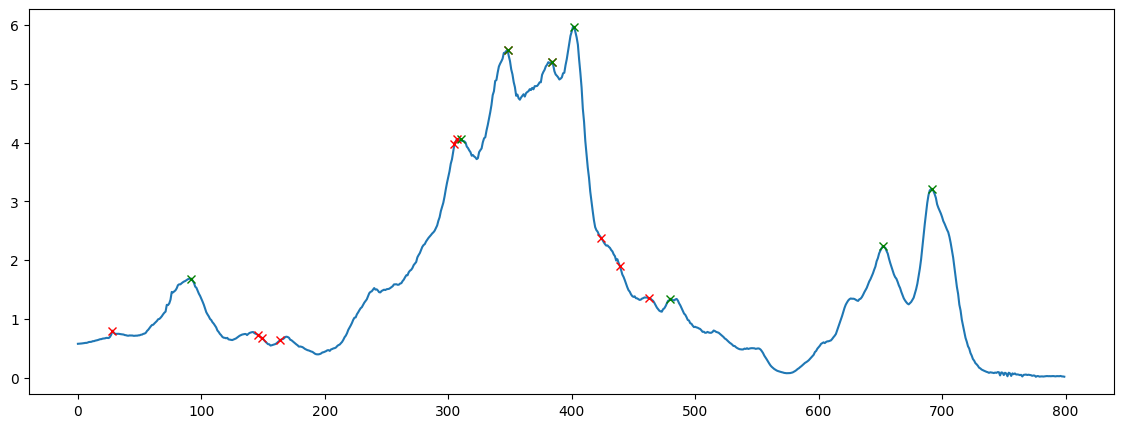

In [39]:
for _ in range(5):
    plot_example(train_dataset, np.random.randint(len(train_dataset)), threshold=0.5)